# Data Analysis of Nuclear Star Cluster Around Merging Black Holes
The goal of this project is to analyze the shape and kinematics of a nuclear star cluster that has formed from the merger of two supermassive black holes and their respective individual star clusters as simulated by __[Mastrobuono-Battisti et. al (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.521.6089M/abstract)__.

The data was procured by direct request from the authors. The data set represents the final snapshot in a simulation of the merger of two nuclear star clusters, each containing a mass of $10^7 M_{\odot}$ (solar masses) with 65,536 equal mass stars bound to a $10^6 M_{\odot}$ black hole. 

My goals and questions for this data set include:
1. Analyze the shape and distribution of stars in the cluser
2. Create a new, synthetic data set that follows the same statistical distibution as the original that can be used to run further simulations using this data as the initial conditions 
3. Transform the data to be in the reference frame of the center of the black hole binary 
4. Create density plots in this reference frame and verify I can reproduce the same results as __[Mastrobuono-Battisti et. al (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.521.6089M/abstract)__
5. Transform the dataset into standard mks (meters, kilograms, seconds) units
6. Determine the fraction of stars in the cluster that is gravitationally bound to the cluster 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import corner
from scipy.stats import gaussian_kde

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [137]:
#set parameters for plots to be applied to all matplotlib plots in notebook 
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
dir = os.getcwd() #path to current working directory 

column_headers = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'm'] #column headers are not included in file
#units in original data file:
#x, y, z: parsecs
#vx, vy, vz: km/s
#m: solar masses

#import data into pandas data frame:
df = pd.read_table(os.path.join(dir,'M5_out_278.00.dat'), names = column_headers) #names option allows manual assigment of column headers


Add new columns the the data frame:

In [4]:
#add column for the radial distance of the star

df['r'] = (df.x**2 + df.y**2 + df.z**2)**(1/2)

In [5]:
#add column for the speed of the star

df['v'] = (df.vx**2 + df.vy**2 + df.vz**2)**(1/2) 

In [6]:
#add column that indicates whether the row contains a star (True) or a black hole (False)

df['star'] = df.m < 200

In [7]:
#add column to indicate which nuclear star cluster the star/bh originated in

iBH2 = df.loc[df['star'] == 0].index[1] #index of second black hole 
df['nsc'] = (df.index >= iBH2) + 1 

In [8]:
df

,x,y,z,vx,vy,vz,m,r,v,star,nsc
0,-18.206940,1.048421,0.377924,-288.633400,93.939710,9.444297,1000000.0000,18.241016,303.682570,False,1
1,-18.359090,-7.793006,-22.969710,-9.956702,-38.537820,-34.352350,152.5879,30.420301,52.577404,True,1
2,-20.737330,-1.065200,-0.677657,20.406420,-43.044410,-24.544950,152.5879,20.775724,53.588224,True,1
3,-28.424980,25.631390,-3.274062,-14.425630,-50.907200,11.449230,152.5879,38.414413,54.136186,True,1
4,-19.185520,12.413090,1.553668,-36.114180,-47.119080,-17.487140,152.5879,22.903774,61.888947,True,1
...,...,...,...,...,...,...,...,...,...,...,...
131069,-19.790940,6.871008,-5.007380,-49.944390,-68.147930,45.973740,152.5879,21.539868,96.188187,True,2
131070,-175.383900,295.630600,-213.239900,-8.005154,-30.529960,-5.690909,152.5879,404.509850,32.070974,True,2
131071,-6.458676,9.193632,-10.842540,-25.933440,3.228664,1.104360,152.5879,15.614033,26.156972,True,2
131072,-20.141900,1.598176,8.706438,-77.156170,-84.107800,-38.799460,152.5879,22.001190,120.551212,True,2


Corner plot:

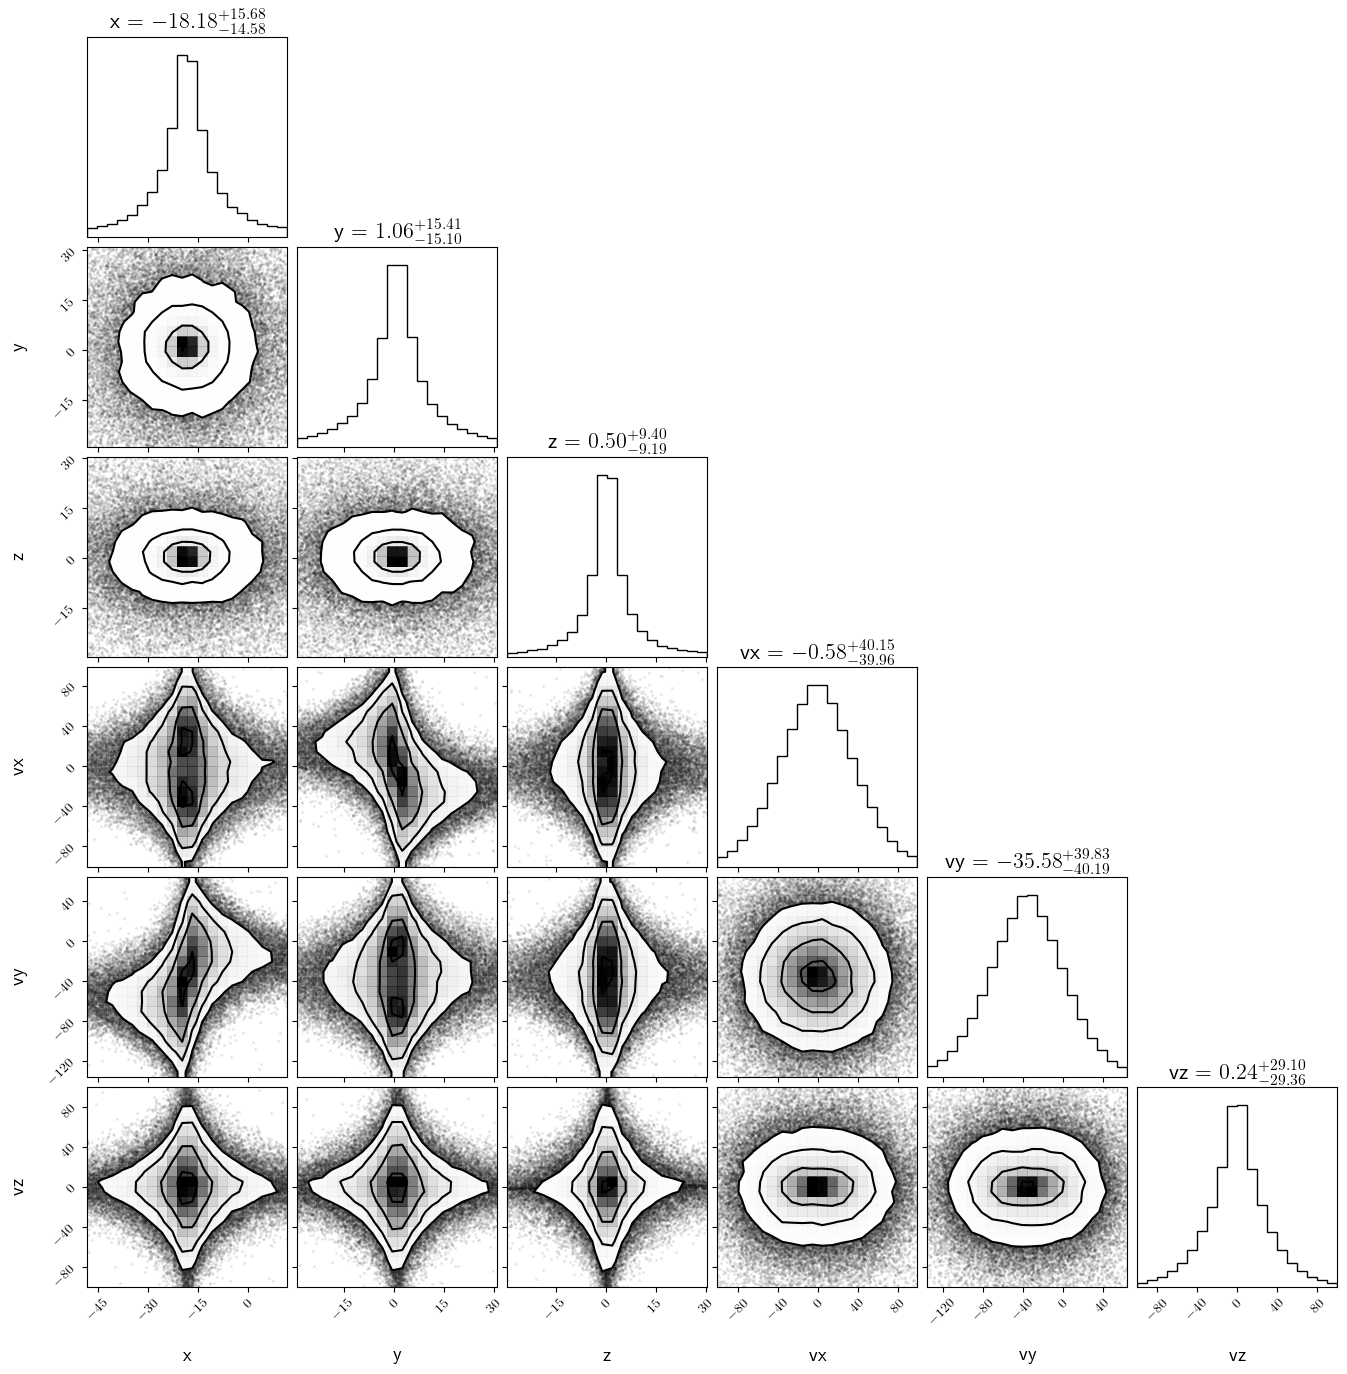

In [127]:
# corner figure of data set 

fig = corner.corner(df.loc[df.star==True][['x','y','z','vx','vy','vz']], range = [(df.x.median()-30,df.x.median()+30), (df.y.median()-30,df.y.median()+ 30), (df.z.median()-30, df.z.median()+30), (df.vx.median()-100, df.vx.median()+100), (df.vy.median()-100, df.vy.median()+100), (df.vz.median()-100, df.vz.median()+100)], labels=df.columns.tolist(), show_titles=True, title_fmt=".2f")


Commentary on dataset:
The corner plot clearly reveals the oblate spheroid shape of the cluster, with a symmetric, circular profile in the xy plane, and a flattened profile in the xz and yz planes. The velocity profiles also reveal that stars are moving much faster in the inner regions of the cluster, and slower as you move radially outward, as would be expected. 

Next, I generate a new, synthetic dataset that follows the same underlying distibution as the original dataset:

In [10]:
# stack our original data into the format that is expected by gaussian_kde

orig_data = np.vstack([df['x'].values, df['y'].values, df['z'].values, df['vx'].values, df['vy'].values, df['vz'].values])

In [11]:
# create the kde. bw_method = .001 value selected for best fit by eye. 

kde = gaussian_kde(orig_data, bw_method = .0001)

In [12]:
#resample the kde to create the synthetic dataset 

new_data = kde.resample(size=len(df['x'].values))

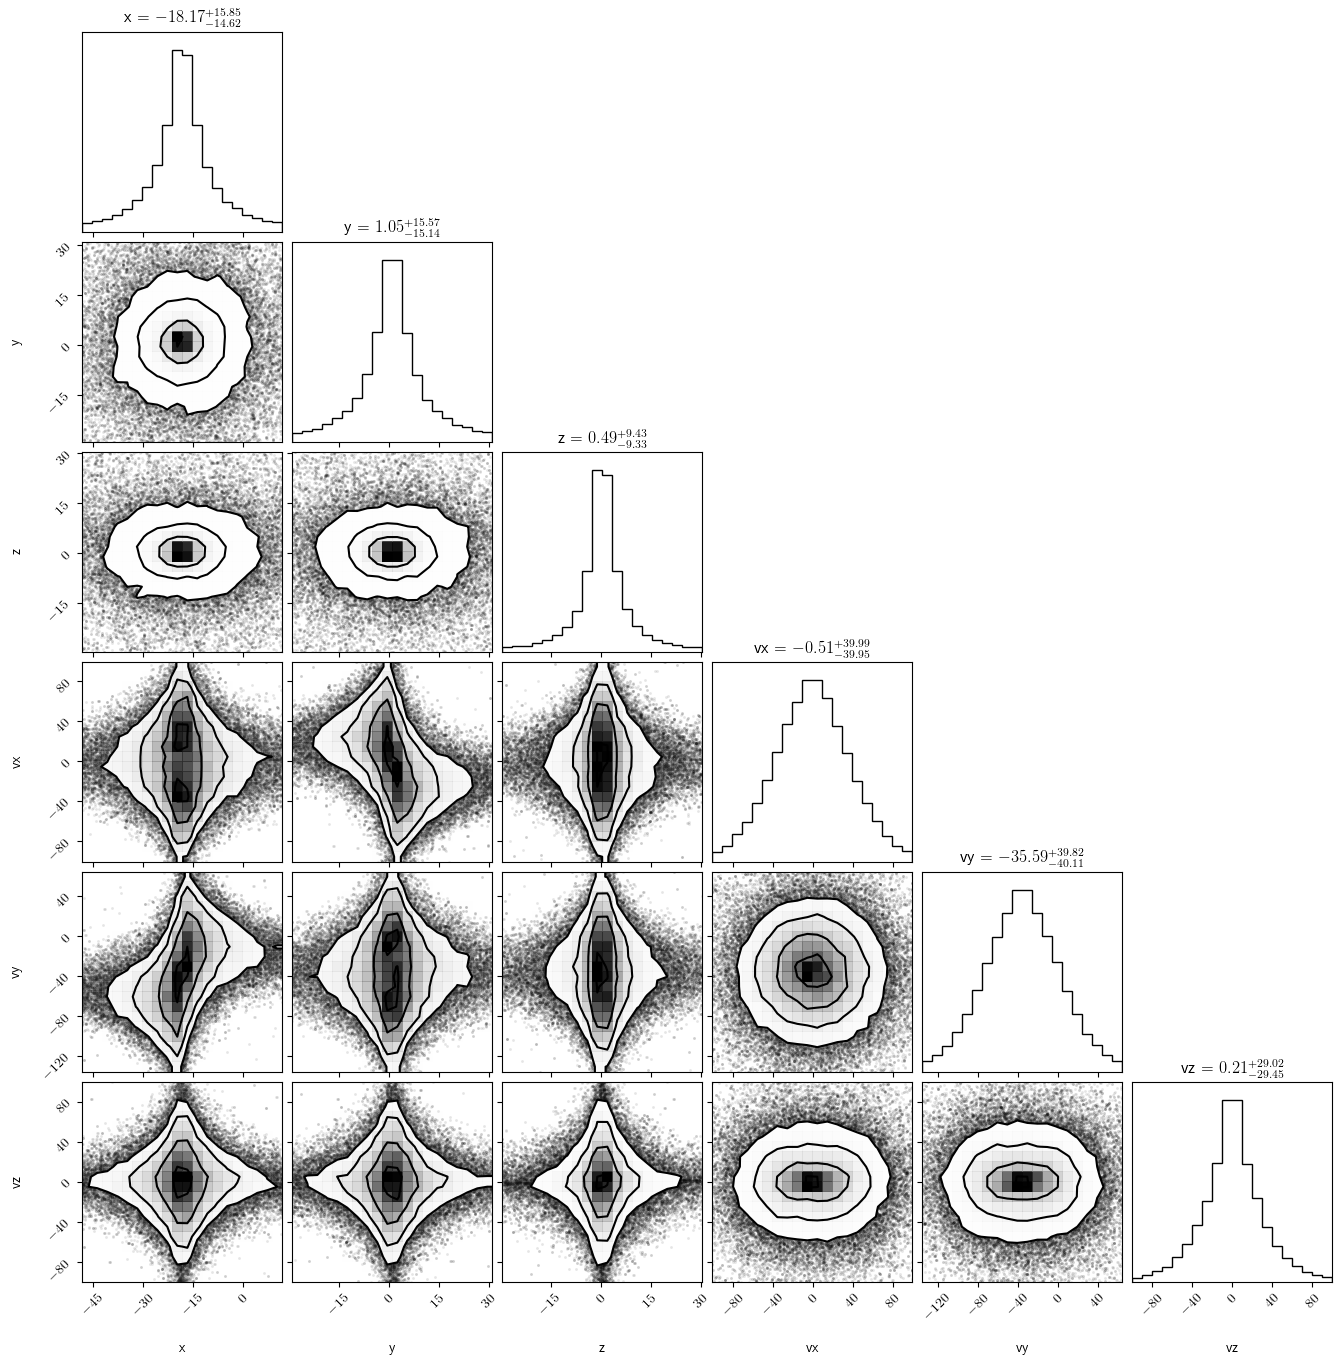

In [13]:
#corner plot using new synthetic data to mirror the one above 

fig = corner.corner(new_data.T, range = [(df.x.median()-30,df.x.median()+30), (df.y.median()-30,df.y.median()+ 30), (df.z.median()-30, df.z.median()+30), (df.vx.median()-100, df.vx.median()+100), (df.vy.median()-100, df.vy.median()+100), (df.vz.median()-100, df.vz.median()+100)], labels=df.columns.tolist(), show_titles=True, title_fmt=".2f")


Determine and move to the black hole's center of mass (com) frame:

In [14]:
#data for the two black holes:
df_bh = df.loc[df["star"]==False].copy()
df_bh

,x,y,z,vx,vy,vz,m,r,v,star,nsc
0,-18.20694,1.048421,0.377924,-288.6334,93.93971,9.444297,1000000.0,18.241016,303.682570,False,1
65537,-18.21712,1.028614,0.377476,285.5273,-172.52600,-12.315550,1000000.0,18.250041,333.830395,False,2


In [15]:
#black holes masses are the same in this dataset, so could just take the average
#but coding the full com caclculation for using this code on a non-equal mass dataset

#also note that this is not the center of mass of the cluster, it is the center of mass of the two black holes
#see commmented code block below for center of mass of entire cluster

x_bh_com = (df_bh.x*df_bh.m).sum() / df_bh.m.sum() 
y_bh_com = (df_bh.y*df_bh.m).sum() / df_bh.m.sum()
z_bh_com = (df_bh.z*df_bh.m).sum() / df_bh.m.sum()

vx_bh_com = (df_bh.vx*df_bh.m).sum() / df_bh.m.sum() 
vy_bh_com = (df_bh.vy*df_bh.m).sum() / df_bh.m.sum()
vz_bh_com = (df_bh.vz*df_bh.m).sum() / df_bh.m.sum()

In [16]:
# #example code for center of mass of entire cluster or each individual cluster:

# #calculate the total center of mass:
# xcom = (df.x*df.m).sum() / df.m.sum()

# #center of mass of each cluster
# xcom1 = (df.loc[df['nsc'] == 1].x*df.loc[df['nsc'] == 1].m).sum() / df.loc[df['nsc'] == 1].m.sum()
# xcom2 = (df.loc[df['nsc'] == 2].x*df.loc[df['nsc'] == 2].m).sum() / df.loc[df['nsc'] == 2].m.sum()

In [17]:
#create a data frame moved the the black hole's center of mass frame

df_com = df.copy()
df_com['x'] = df_com['x'] - x_bh_com
df_com['y'] = df_com['y'] - y_bh_com
df_com['z'] = df_com['z'] - z_bh_com
df_com['vx'] = df_com['vx'] - vx_bh_com
df_com['vy'] = df_com['vy'] - vy_bh_com
df_com['vz'] = df_com['vz'] - vz_bh_com

df_com['r'] = (df_com.x**2 + df_com.y**2 + df_com.z**2)**(1/2)
df_com['v'] = (df_com.vx**2 + df_com.vy**2 + df_com.vz**2)**(1/2) 

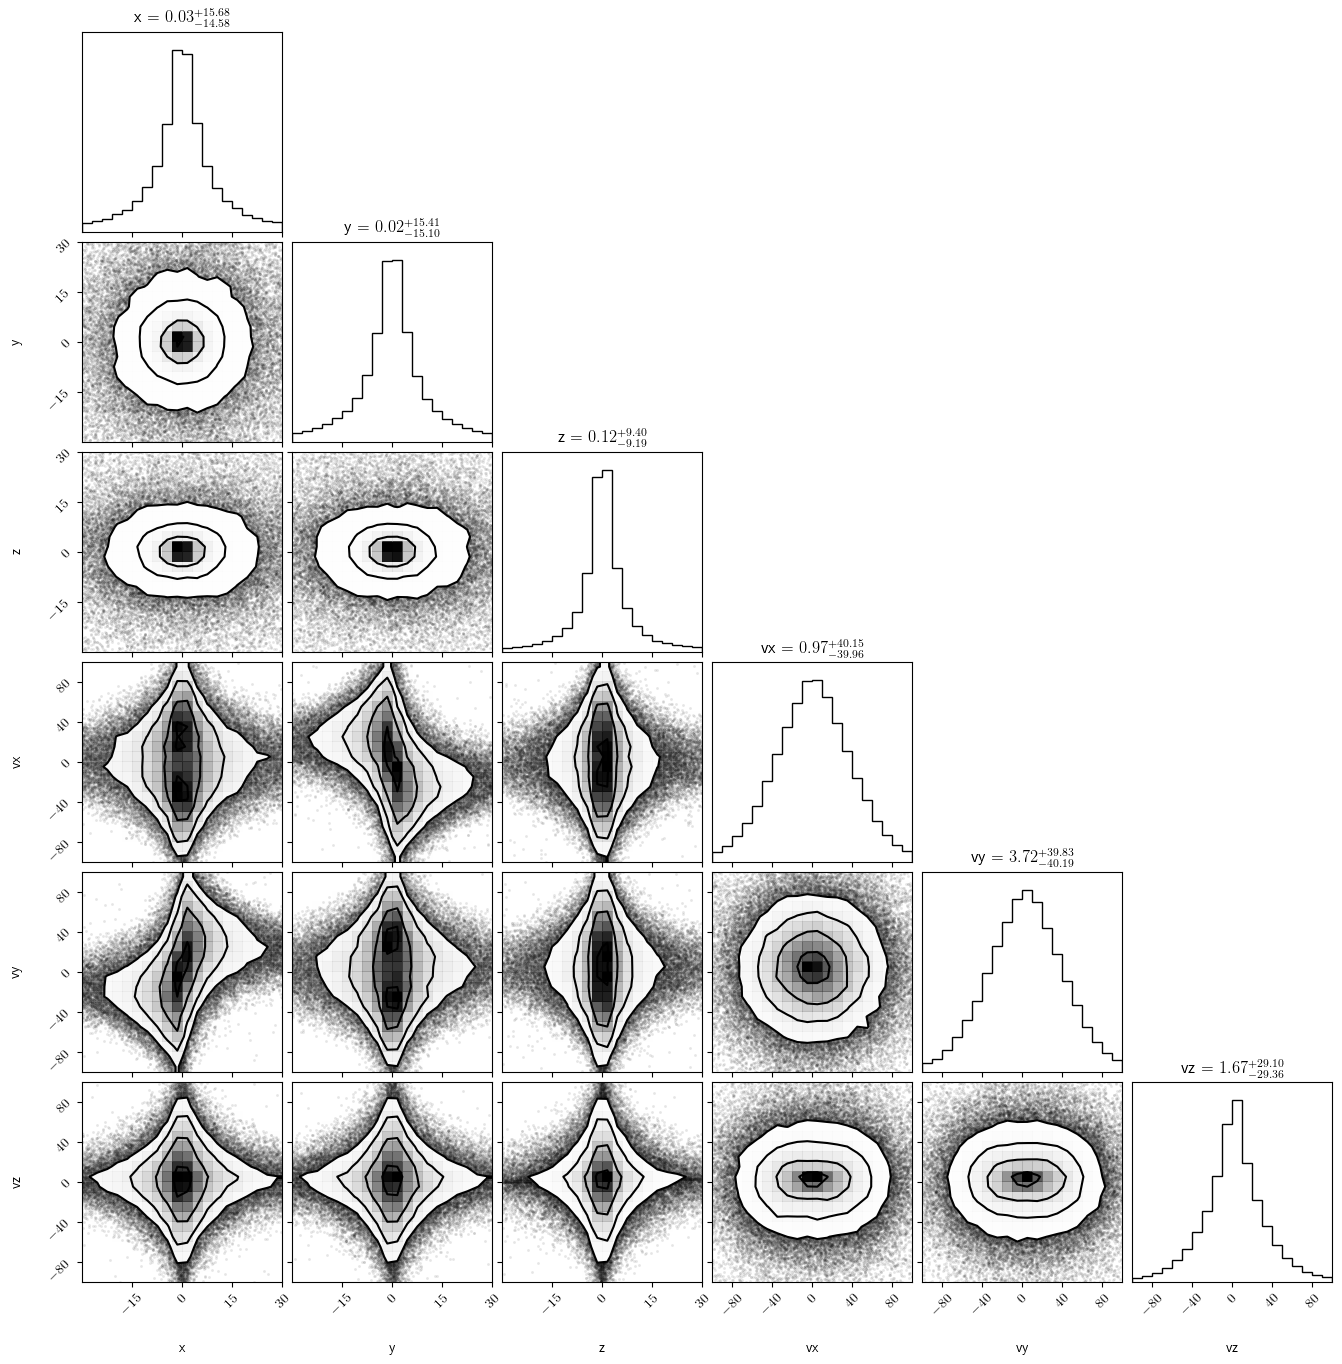

In [18]:
#new corner plot with com data
#note that median has been removed in range definition 

fig = corner.corner(df_com.loc[df_com.star==True][['x','y','z','vx','vy','vz']], range = [(-30,30),(-30,30), (-30,30), (-100,100), (-100,100), (-100,100)], labels=df_com.columns.tolist(), show_titles=True, title_fmt=".2f")


Determine density profile of cluster and make sure it reproduces results in __[Mastrobuono-Battisti et. al (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.521.6089M/abstract)__:

In [19]:
#masses of the stars and black holes
m_star = df.iloc[1].m
m_bh = df.iloc[0].m

In [171]:
#create radial bins for measuring the mass density 
r_smooth_lin = np.linspace(0.1, 100, 100)
r_smooth_log = np.logspace(-1, 3, 100)


In [172]:
#calculate the density in each radial shell moving outward 
density_r = []
for i, r in enumerate(r_smooth_log):
    dr = r_smooth_log[i]-r_smooth_log[i-1]
    volume = 4/3 *np.pi *r**3 - 4/3 *np.pi *(r-dr)**3
    N = len(df_com.loc[df_com.r < r]) - len(df_com.loc[df_com.r < (r-dr)])
    density_r.append(m_star *N/volume)

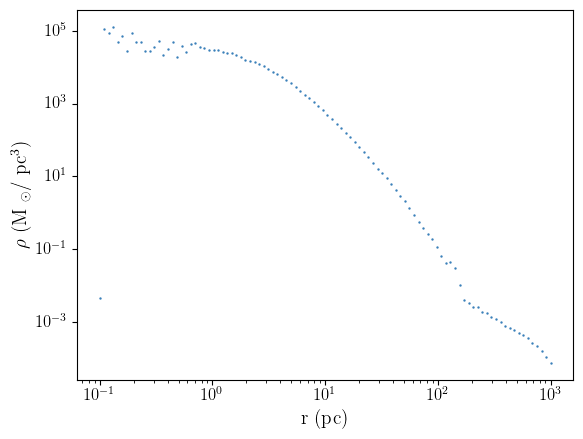

In [173]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$\\rho$ (M $_{\\odot}/$ pc$^3$)')
ax.set_xlabel('r (pc)')
ax.scatter(r_smooth_log, density_r, .5)

In [150]:
#calculate the cummulative mass distribution
mass_r = []
for r in r_smooth_lin:
    mass_r.append(m_star*len(df_com.loc[df_com.r < r]))

Text(0.5, 0, 'r (pc)')

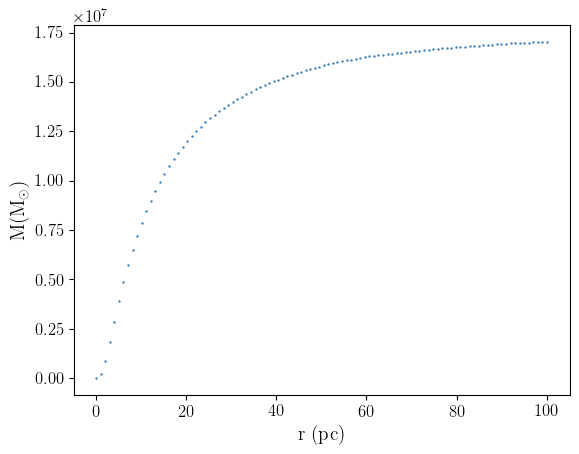

In [152]:
fig, ax = plt.subplots()
ax.scatter(r_smooth_lin, mass_r, .5)
ax.set_ylabel('M(M$_{\\odot})$')
ax.set_xlabel('r (pc)')


These plots reproduce the results in figure 3 of __[Mastrobuono-Battisti et. al (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.521.6089M/abstract)__, successfully verifying my treatment of the data. 

Next, create a new data frame in converting to mks units:

In [25]:
# mks unit converstions factors

G = 6.674*10**-11 #Gravitational constant in mks                                                                                                                                                                          
kg_per_solar = 1.9891*10**30 #mass of sun in kg
m_per_pc = 3.086*10**16 #convert from parsec to meters



# #Note that the energy calculations below could also be done in the original units by using G in these astrophysical units instead:
#G_astro =  4.3*10**-3 #Gravitational constant in (km/s)^2 pc Msun^-1

In [26]:
#new data frame in mks units

df_mks = df_com.copy()

df_mks.x = df_mks.x * m_per_pc  #convert from pc to m
df_mks.y = df_mks.y * m_per_pc
df_mks.z = df_mks.z * m_per_pc
df_mks.r = df_mks.r * m_per_pc
df_mks.vx = df_mks.vx * 1000 #convert from km/s to m/s
df_mks.vy = df_mks.vy * 1000
df_mks.vz = df_mks.vz * 1000
df_mks.v = df_mks.v * 1000
df_mks.m = df_mks.m * kg_per_solar #convert from solar masses to kg

In [28]:
r_array = df_mks[['x', 'y', 'z']].to_numpy() 
v_array = df_mks[['vx', 'vy', 'vz']].to_numpy()

In [29]:
#specific angular momentum 
h_array = np.cross(r_array, v_array)

In [108]:
#point-wise gravitational potential 
df_mks['U'] = 0.0 #make empty new column 

#this will take several minutes to run
for i in range(len(df_mks)): #select each star
    df_loop = (df_mks.copy()).drop([i], axis=0) #create df that excludes the current star
    U = -G*df_mks['m'][i]  \
        * np.sum(df_loop['m'].values \
        / np.sqrt((df_loop['x'].values - df_mks['x'][i])**2 \
        + (df_loop['y'].values - df_mks['y'][i])**2 \
        + (df_loop['z'].values - df_mks['z'][i])**2)  )
    df_mks.loc[i, "U"] = U
        

1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 more down!
1000 mor

In [110]:
# kinetic energy of each particle
df_mks['K'] = .5 * df_mks["m"] * df_mks["v"]**2

In [112]:
#total mechanical energy of each particle 
df_mks['E'] = df_mks["K"] + df_mks["U"]

In [113]:
df_mks

,x,y,z,vx,vy,vz,m,r,v,star,nsc,U,K,E
0,1.570774e+14,3.056220e+14,6.909554e+12,-287080.350,133232.855,10879.9235,1.989100e+36,3.436944e+14,316677.270645,False,1,5.291046e+47,9.973794e+46,-4.293666e+47
1,-4.538272e+15,-2.725408e+17,-7.205011e+17,-8403.652,755.325,-32916.7235,3.035126e+32,7.703382e+17,33980.914772,True,1,8.905383e+41,1.752334e+41,-7.153049e+41
2,-7.793076e+16,-6.492072e+16,-3.256834e+16,21959.470,-3751.265,-23109.3235,3.035126e+32,1.065298e+17,32098.771696,True,1,3.449710e+42,1.563592e+41,-3.293351e+42
3,-3.151716e+17,7.589360e+17,-1.126934e+17,-12872.580,-11614.055,12884.8565,3.035126e+32,8.294678e+17,21601.136924,True,1,8.894247e+41,7.081087e+40,-8.186138e+41
4,-3.004190e+16,3.510193e+17,3.629036e+16,-34561.130,-7825.935,-16051.5135,3.035126e+32,3.541667e+17,38902.031453,True,1,1.749278e+42,2.296631e+41,-1.519615e+42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131069,-4.872516e+16,1.799907e+17,-1.661836e+17,-48391.340,-28854.785,47409.3665,3.035126e+32,2.497754e+17,73634.016842,True,2,2.117029e+42,8.228178e+41,-1.294211e+42
131070,-4.850324e+18,9.091112e+18,-6.592239e+18,-6452.104,8763.185,-4255.2825,3.035126e+32,1.223240e+19,11684.626076,True,2,6.747592e+40,2.071936e+40,-4.675655e+40
131071,3.627085e+17,2.516668e+17,-3.462566e+17,-24380.390,42521.809,2539.9865,3.035126e+32,5.610591e+17,49081.149015,True,2,1.192423e+42,3.655747e+41,-8.268484e+41
131072,-5.955579e+16,1.727106e+16,2.570248e+17,-75603.120,-44814.655,-37363.8335,3.035126e+32,2.643992e+17,95499.953457,True,2,1.990312e+42,1.384054e+42,-6.062576e+41


In [119]:
#ratio of unbound to bound stars:

len(df_mks.loc[df_mks.E > 0])/len(df_mks.loc[df_mks.E < 0])

0.12269912376123136